<a href="https://colab.research.google.com/github/JonamManoj/MscDissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install pandas
!pip install scipy

In [23]:
import pandas as pd
from scipy.io import arff

In [24]:
!pip install ucimlrepo

In [25]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# data (as pandas dataframes)
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

# metadata
print(chronic_kidney_disease.metadata)

# variable information
print(chronic_kidney_disease.variables)


{'uci_id': 336, 'name': 'Chronic Kidney Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/336/data.csv', 'abstract': 'This dataset can be used to predict the chronic kidney disease and it can be collected from the hospital nearly 2 months of period.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 400, 'num_features': 24, 'feature_types': ['Real'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5G020', 'creators': ['L. Rubini', 'P. Soundarapandian', 'P. Eswaran'], 'intro_paper': None, 'additional_info': {'summary': 'We use the following representation to collect the dataset\r\n                        age\t\t-\tage\t\r\n\t\t\tbp\t\t-\tblood pressure\r\n\t\t\tsg\t

In [26]:
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

In [27]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [28]:
ckd_df = pd.concat([X_df, y_df], axis=1)

In [29]:
ckd_df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import shap

In [31]:
numeric_cols = ckd_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ckd_df.select_dtypes(include=['object']).columns

In [32]:
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [33]:
ckd_df[numeric_cols] = numeric_imputer.fit_transform(ckd_df[numeric_cols])
ckd_df[categorical_cols] = categorical_imputer.fit_transform(ckd_df[categorical_cols])

In [34]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    ckd_df[col] = le.fit_transform(ckd_df[col])
    label_encoders[col] = le

In [35]:
X = ckd_df.drop(columns=['class'])
y = ckd_df['class']

In [36]:
X.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,15.4,44.0,7800.0,5.200000,1,2,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,148.036517,...,11.3,38.0,6000.0,4.707435,0,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,9.6,31.0,7500.0,4.707435,0,2,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,11.2,32.0,6700.0,3.900000,1,1,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,11.6,35.0,7300.0,4.600000,0,1,0,0,0,0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC(probability=True, random_state=42)
ann_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42,early_stopping=True,alpha=0.0001)

In [40]:
models = {
    'Random Forest': rf_model,
    'K-Nearest Neighbors': knn_model,
    'Support Vector Machine': svm_model,
    'Artificial Neural Network': ann_model
}

In [41]:
y_train = y_train.replace({2: 1})
y_test = y_test.replace({2: 1})
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       1.00      0.93      0.97        30

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80

Random Forest ROC-AUC Score: 0.9993333333333333
Random Forest Cross-Validation ROC-AUC Scores: [0.92712551 1.         1.         1.         1.         1.
 0.92083333 1.         0.9875     1.        ]
Random Forest Mean CV ROC-AUC: 0.9835458839406208

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       0.94      1.00      0.97        30

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80

K-Nearest Ne

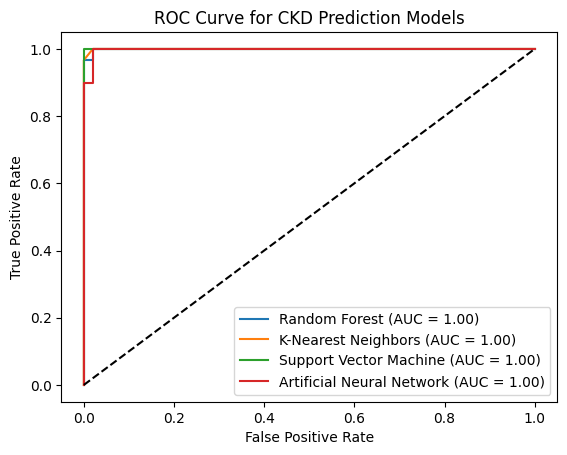

In [42]:
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluate only if both classes are present in y_test
    if len(set(y_test)) == 2:
        print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))
        if y_proba is not None:
            print(f"{model_name} ROC-AUC Score:", roc_auc_score(y_test, y_proba))

            # Plot ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")
    else:
        print(f"\n{model_name}: Skipping ROC-AUC and ROC Curve due to single-class data in y_test.")
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='roc_auc')
    print(f"{model_name} Cross-Validation ROC-AUC Scores:", cv_scores)
    print(f"{model_name} Mean CV ROC-AUC:", cv_scores.mean())
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CKD Prediction Models")
plt.legend()
plt.show()
